In [1]:
# loading file, parallelizing, removing first row, as it is a header
fileName = '/FileStore/tables/marathon_results_2015.csv'

numPartitions = 8
rawData = sc.textFile(fileName, numPartitions)

header = rawData.first() #extracting header
print('Columns: ', header)

rawData = rawData.filter(lambda row : row != header)   #filtering out header
print('Number of datapoints', rawData.count())   # how many records we have in the dataset
print(rawData.take(5))

Columns: ,Bib,Name,Age,M/F,City,State,Country,Citizen,,5K,10K,15K,20K,Half,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender,Division
Number of datapoints 26598
['0,3,"Desisa, Lelisa",25,M,Ambo,,ETH,,,0:14:43,0:29:43,0:44:57,1:00:29,1:04:02,1:16:07,1:32:00,1:47:59,2:02:39,0:04:56,-,2:09:17,1,1,1', '1,4,"Tsegay, Yemane Adhane",30,M,Addis Ababa,,ETH,,,0:14:43,0:29:43,0:44:58,1:00:28,1:04:01,1:16:07,1:31:59,1:47:59,2:02:42,0:04:58,-,2:09:48,2,2,2', '2,8,"Chebet, Wilson",29,M,Marakwet,,KEN,,,0:14:43,0:29:43,0:44:57,1:00:29,1:04:02,1:16:07,1:32:00,1:47:59,2:03:01,0:04:59,-,2:10:22,3,3,3', '3,11,"Kipyego, Bernard",28,M,Eldoret,,KEN,,,0:14:43,0:29:44,0:45:01,1:00:29,1:04:02,1:16:07,1:32:00,1:48:03,2:03:47,0:05:00,-,2:10:47,4,4,4', '4,10,"Korir, Wesley",32,M,Kitale,,KEN,,,0:14:43,0:29:44,0:44:58,1:00:28,1:04:01,1:16:07,1:32:00,1:47:59,2:03:27,0:05:00,-,2:10:49,5,5,5']

In [2]:
# we will be predicting finishing time
# we will ignore some columns, e.g. Name, City, State, Country, Citizen, etc.
# we will only use split times before 30K and some other features: age, gender

In [3]:
# parsing dataset from lines to features
# parsing a line here: our label is in column number 22, features are in some other columns
# also in the file missing values are typed as '-'
# as there are small amount of them (around 1%) we will just ignore them
# they will be filtered out 
# convertions: split times and finishing time to seconds(float) from strings
# convertions: age to integer, gender to 1/0
import string
from datetime import timedelta, datetime
from pyspark.mllib.regression import LabeledPoint
import numpy as np

def toSeconds(str):
  # we have missing values and some weird values
  # in such cases will consider time=0 and filter them out later
  try:
    time = datetime.strptime(str,'%H:%M:%S')
  except ValueError:
    time = datetime.strptime('0:0:0','%H:%M:%S')
  delta = timedelta(hours=time.hour, minutes=time.minute, seconds=time.second)
  return delta.total_seconds()

def parsePoint(line):
  line = line.replace('-','')   # replacing '-' with empty string
  splitted = line.split(',')    # spliting line
  label=toSeconds(splitted[22])   # taking label,converting to time and calculating number of seconds in the function toSeconds defined above
  features=[]  #adding features below
  features.append(toSeconds(splitted[11])) # 5k
  features.append(toSeconds(splitted[12])) # 10k
  features.append(toSeconds(splitted[13])) # 15K
  features.append(toSeconds(splitted[14])) # 20K
  features.append(toSeconds(splitted[16])) # 25K
  features.append(toSeconds(splitted[17])) # 30K
  try:
    age = int(splitted[4])
  except ValueError:
    age = 0
  features.append(age)       # age
  if splitted[5]=="M":
    gender=1
  elif splitted[5]=="F":
    gender=0
  else:
    gender=-1
  features.append(gender)     # gender
  
  return LabeledPoint(label, features)

parsedData = rawData.map(parsePoint)
print(parsedData.take(1))   # that is how our RDD looks like after parsing
print(parsedData.count())

[LabeledPoint(7757.0, [883.0,1783.0,2697.0,3629.0,4567.0,5520.0,25.0,1.0])]
26598

In [4]:
# filtering missing and weird data
# where we put value=0 and -1 for gender
cleanData = parsedData.filter(lambda lp : lp.label!=0)
cleanData = cleanData.filter(lambda lp : lp.features[0]!=0)
cleanData = cleanData.filter(lambda lp : lp.features[1]!=0)
cleanData = cleanData.filter(lambda lp : lp.features[2]!=0)
cleanData = cleanData.filter(lambda lp : lp.features[3]!=0)
cleanData = cleanData.filter(lambda lp : lp.features[4]!=0)
cleanData = cleanData.filter(lambda lp : lp.features[5]!=0)
cleanData = cleanData.filter(lambda lp : lp.features[6]!=0)
cleanData = cleanData.filter(lambda lp : lp.features[7]!=-1)
print(cleanData.count())    # we lost ~1% of the datapoints

26255

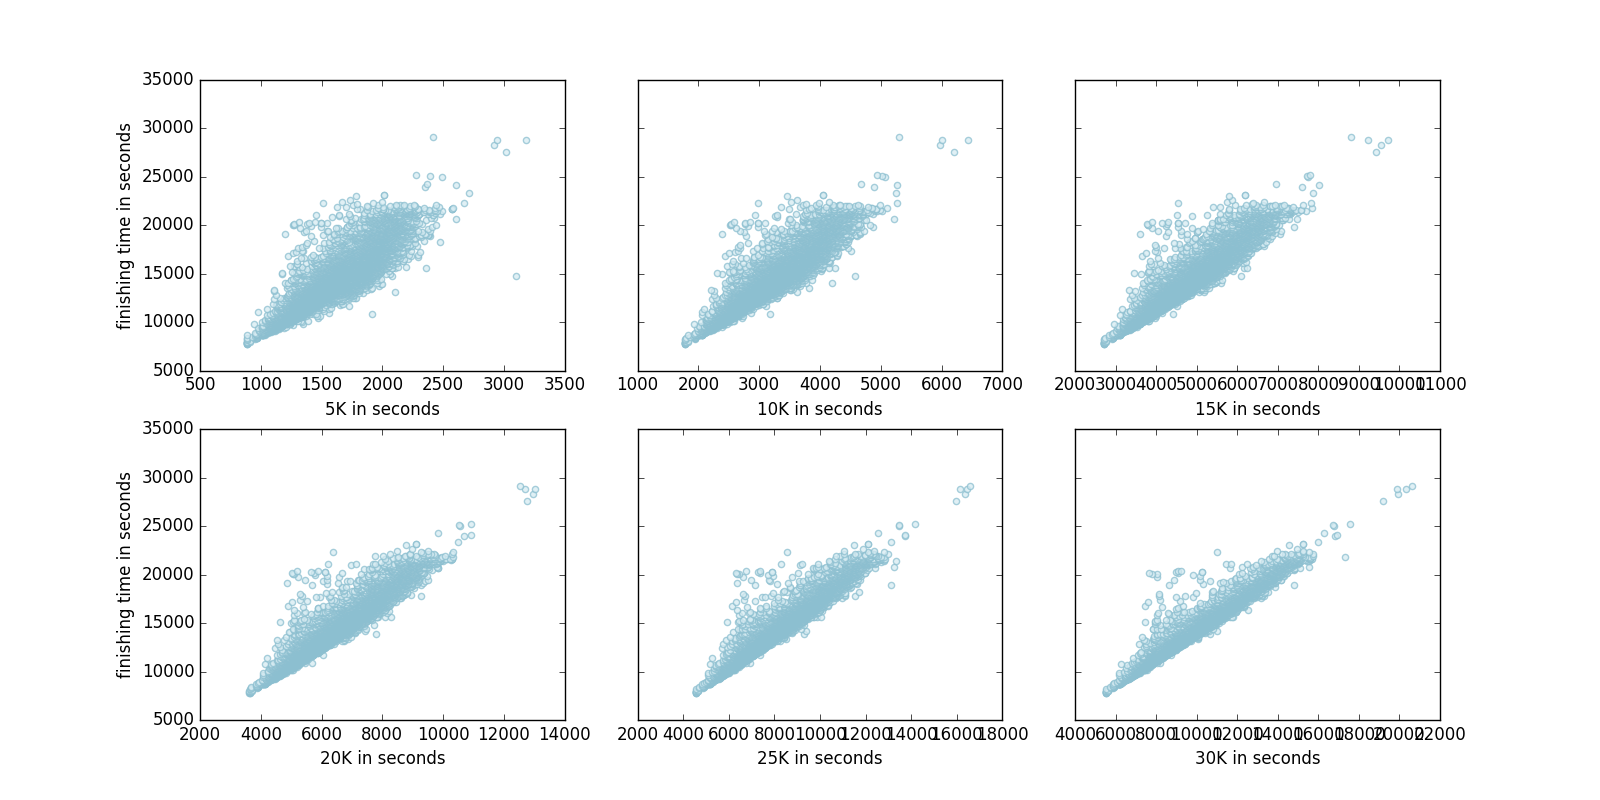

In [5]:
# making sense of the data: scatter plots for split times against finishing time
import matplotlib.pyplot as plt

# get data for plot
plottingData = cleanData.map(lambda lp: (lp.label, lp.features[0], lp.features[1], lp.features[2], lp.features[3], lp.features[4], lp.features[5], lp.features[6])).collect()
y, x0, x1, x2, x3, x4, x5, x6 = zip(*plottingData)  # I start with index=0 for independent variables, to match index in features, that way it is less confusing

#plotting: 3 subplots in each of 2 rows
fig, axs = plt.subplots(2, 3, sharey=True,  figsize=(16, 8))
axs[0][0].scatter(x=x0, y=y, alpha=0.75, c='#d6ebf2', edgecolors='#8cbfd0')
axs[0][1].scatter(x=x1, y=y, alpha=0.75, c='#d6ebf2', edgecolors='#8cbfd0')
axs[0][2].scatter(x=x2, y=y, alpha=0.75, c='#d6ebf2', edgecolors='#8cbfd0')
axs[1][0].scatter(x=x3, y=y, alpha=0.75, c='#d6ebf2', edgecolors='#8cbfd0')
axs[1][1].scatter(x=x4, y=y, alpha=0.75, c='#d6ebf2', edgecolors='#8cbfd0')
axs[1][2].scatter(x=x5, y=y, alpha=0.75, c='#d6ebf2', edgecolors='#8cbfd0')
# adding labels
axs[0][0].set_xlabel('5K in seconds')
axs[0][0].set_ylabel('finishing time in seconds')
axs[0][1].set_xlabel('10K in seconds')
axs[0][2].set_xlabel('15K in seconds')
axs[1][0].set_ylabel('finishing time in seconds')
axs[1][0].set_xlabel('20K in seconds')
axs[1][1].set_xlabel('25K in seconds')
axs[1][2].set_xlabel('30K in seconds')

display(fig)

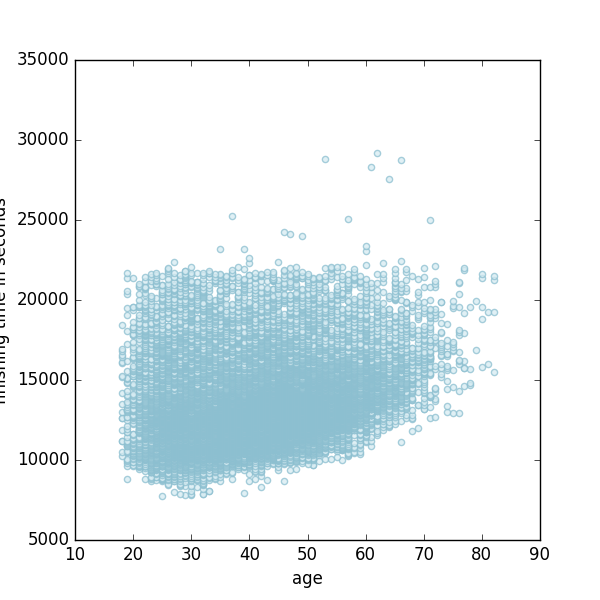

In [6]:
# making sense of the data: scatter plot for age against finishing time
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.scatter(x=x6, y=y, alpha=0.75, c='#d6ebf2', edgecolors='#8cbfd0')
ax.set_xlabel('age')
ax.set_ylabel('finishing time in seconds')
display(fig)

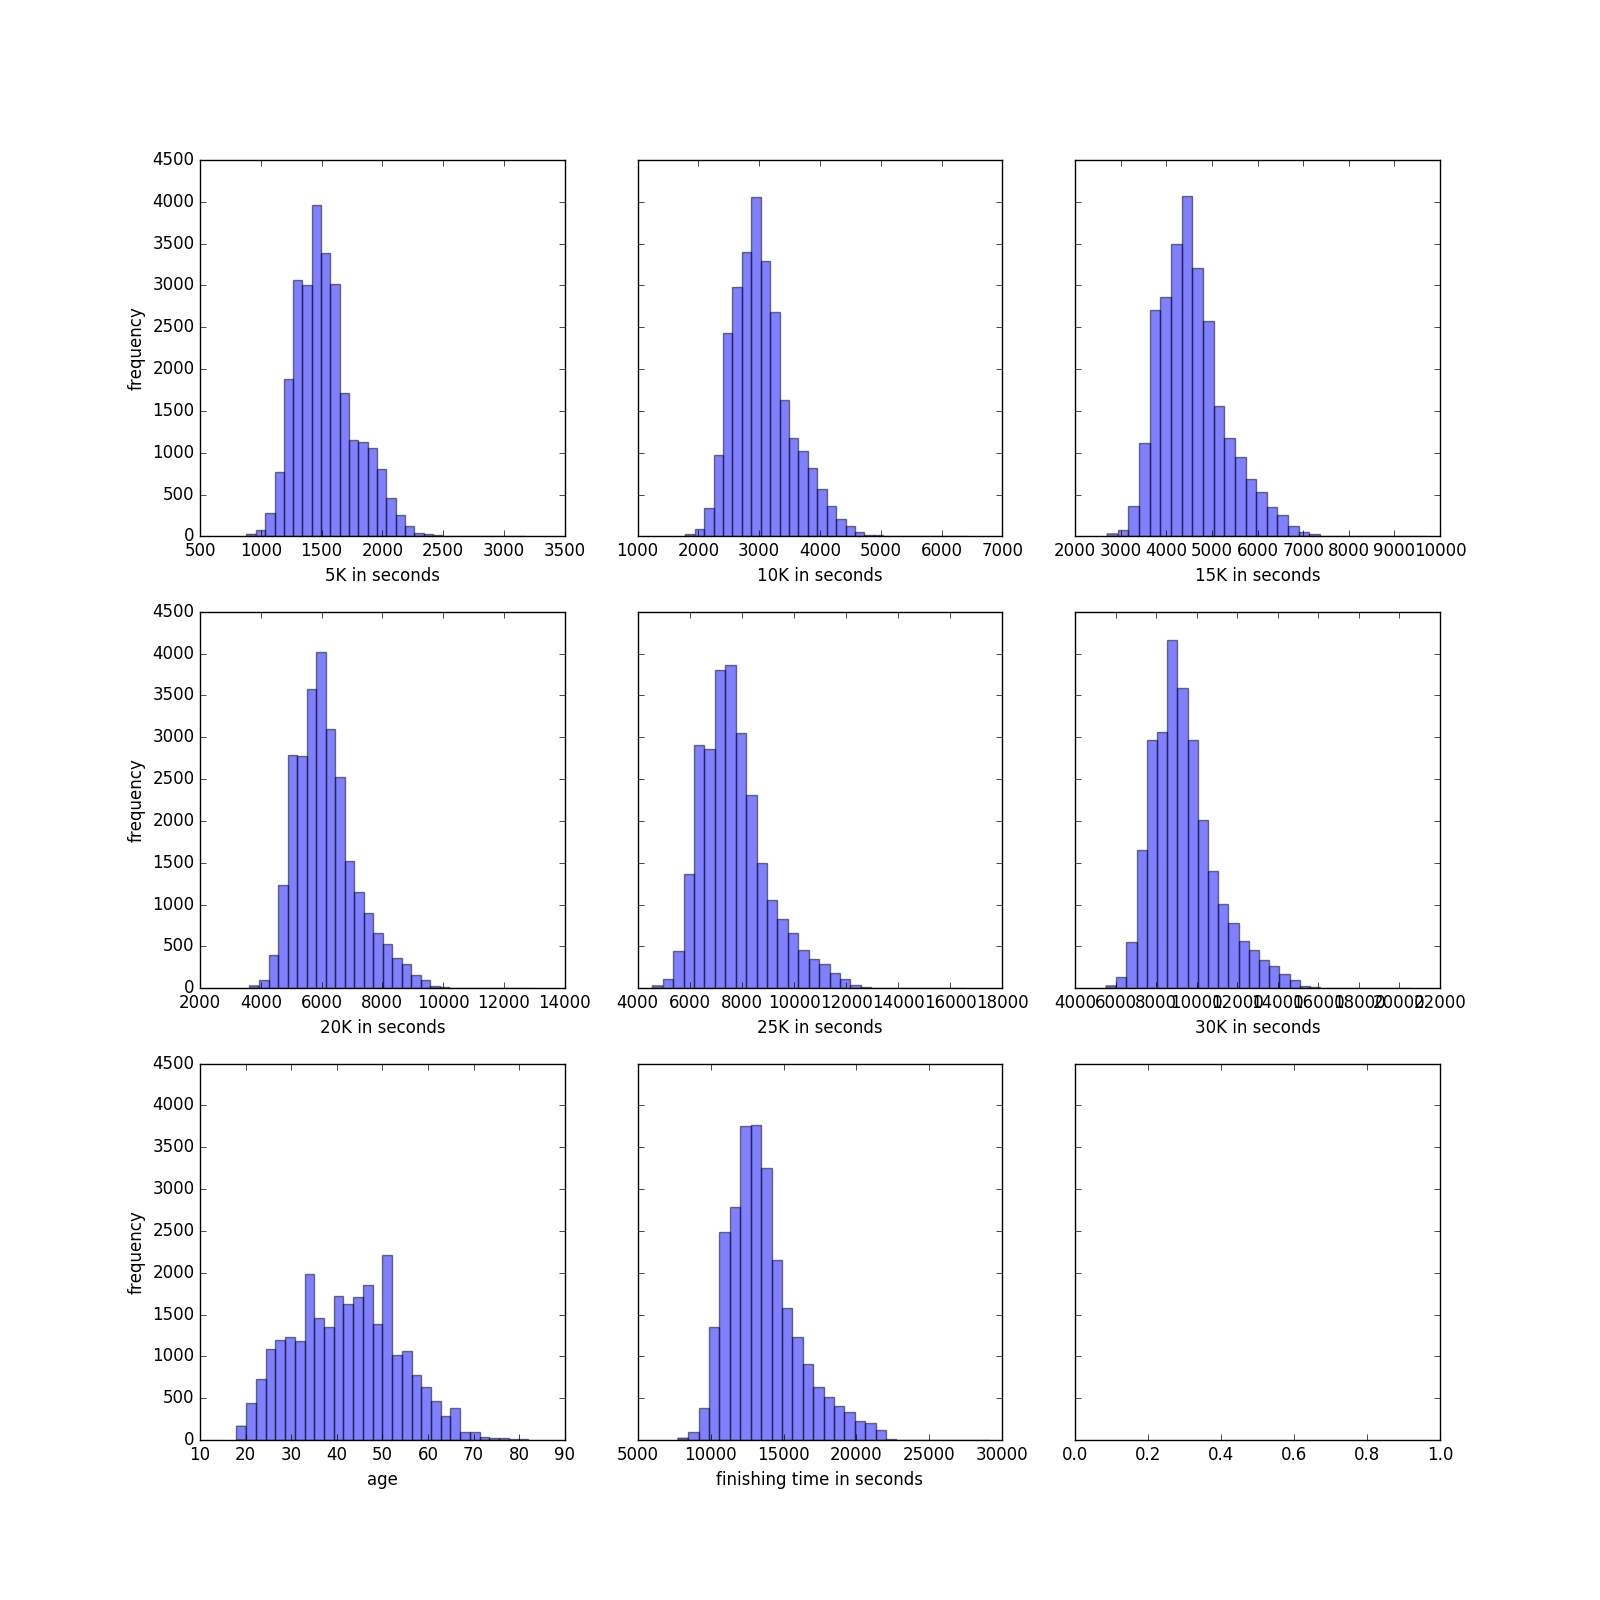

In [7]:
# making sense of the data: histograms
fig, axs = plt.subplots(3, 3, sharey=True,  figsize=(16, 16))
num_bins = 30
n, bins, patches = axs[0][0].hist(x0, num_bins, facecolor='blue', alpha=0.5)
n, bins, patches = axs[0][1].hist(x1, num_bins, facecolor='blue', alpha=0.5)
n, bins, patches = axs[0][2].hist(x2, num_bins, facecolor='blue', alpha=0.5)
n, bins, patches = axs[1][0].hist(x3, num_bins, facecolor='blue', alpha=0.5)
n, bins, patches = axs[1][1].hist(x4, num_bins, facecolor='blue', alpha=0.5)
n, bins, patches = axs[1][2].hist(x5, num_bins, facecolor='blue', alpha=0.5)
n, bins, patches = axs[2][0].hist(x6, num_bins, facecolor='blue', alpha=0.5)
n, bins, patches = axs[2][1].hist(y, num_bins, facecolor='blue', alpha=0.5)
#labels
axs[0][0].set_ylabel('frequency')
axs[0][0].set_xlabel('5K in seconds')
axs[0][1].set_xlabel('10K in seconds')
axs[0][2].set_xlabel('15K in seconds')
axs[1][0].set_ylabel('frequency')
axs[1][0].set_xlabel('20K in seconds')
axs[1][1].set_xlabel('25K in seconds')
axs[1][2].set_xlabel('30K in seconds')
axs[2][0].set_xlabel('age')
axs[2][0].set_ylabel('frequency')
axs[2][0].set_xlabel('age')
axs[2][1].set_xlabel('finishing time in seconds')
display(fig) 

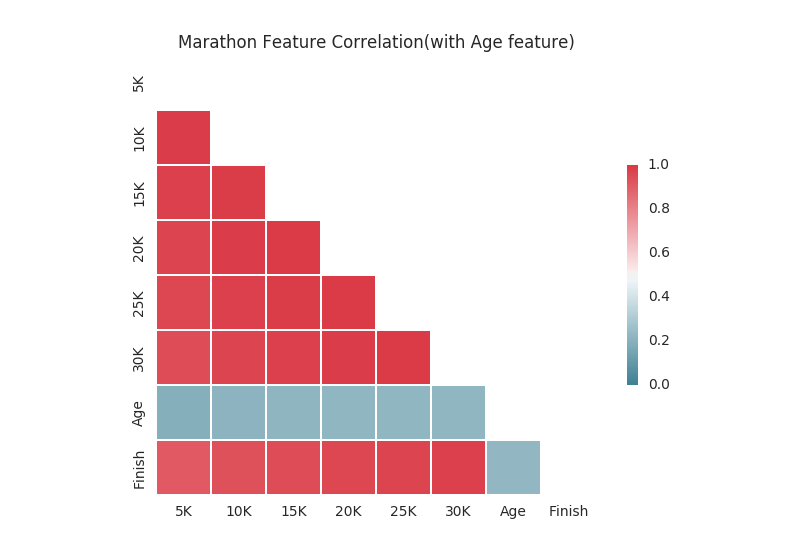

In [8]:
# looking at correlations (includes age)
import numpy as np 
corrMatrix = np.corrcoef([x0,x1,x2,x3,x4,x5,x6,y])  #correlation matrix

from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

# code (below) for heat map taken from internet
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Marathon Feature Correlation(with Age feature)')
labels=['5K','10K','15K','20K','25K','30K','Age', 'Finish']
ax.set_xticklabels(labels,fontsize=10)
ax.set_yticklabels(labels,fontsize=10)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=1, center=0.5, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
display(fig)


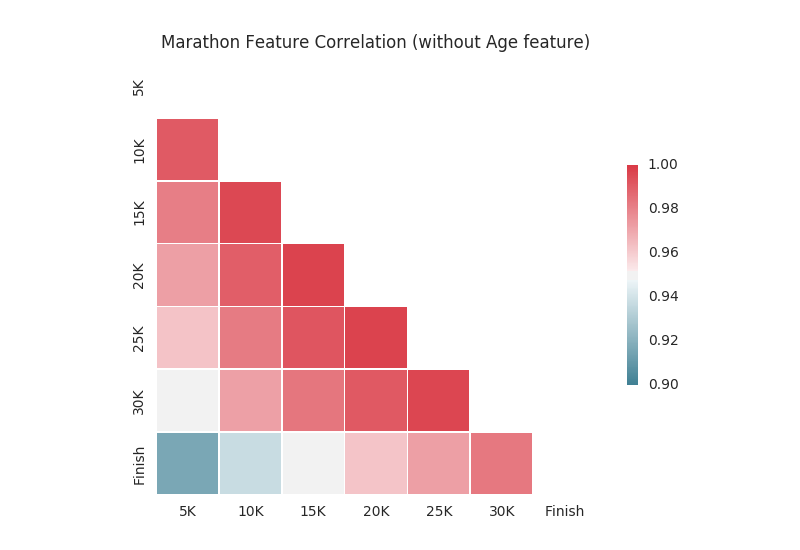

In [9]:
# looking at correlations (excludes age)
corrMatrix = np.corrcoef([x0,x1,x2,x3,x4,x5,y])

mask = np.zeros_like(corrMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots()

plt.title('Marathon Feature Correlation (without Age feature)')
labels=['5K','10K','15K','20K','25K','30K','Finish']
ax.set_xticklabels(labels,fontsize=10)
ax.set_yticklabels(labels,fontsize=10)

sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=1, center=0.95, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=labels, yticklabels=labels)
display(fig)

In [10]:
# splitting data: trainData, valData, testData
weights = [.8, .1, .1]
seed = 150
trainData, valData, testData = cleanData.randomSplit(weights, seed)
trainData.cache().take(1)
valData.cache().take(1)
testData.cache().take(1)

Out[ 10 ]: [LabeledPoint(7847.0, [883.0,1784.0,2701.0,3629.0,4567.0,5520.0,28.0,1.0])]

In [11]:
# defining constants (using them later)
f_5k = 0
f_10k = 1
f_15k = 2
f_20k = 3
f_25k = 4
f_30k = 5
f_age = 6
f_gender = 7

In [12]:
# different sets of features we will try them below with different models
# if I use feature f_gender which is feature #7 in RDD, I will put it first
# that way it is easier to specify it as categorical feature later in decision tree and random forest models (below)
Features = [[f_gender, f_5k, f_10k, f_15k, f_20k, f_25k, f_30k, f_age],
            [f_5k, f_10k, f_15k, f_20k, f_25k, f_30k, f_age],
            [f_30k, f_age],
            [f_gender, f_30k, f_age],
            [f_gender, f_30k],
            [f_5k, f_10k, f_15k, f_20k, f_25k, f_30k],
            [f_10k, f_15k, f_20k, f_25k, f_30k],
            [f_15k, f_20k, f_25k, f_30k],
            [f_20k, f_25k, f_30k],
            [f_25k, f_30k],
            [f_30k]]

In [13]:
# since our split features are strongly correlated with the finishing time, our data is a good candidate for training linear regresson model
# trying Linear Regression model
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.regression import LinearRegressionWithSGD

# trying different sets of features
# and different parameters (alphas)

bestAdjR2 = 0
RegParams = [1e-10, 1e-5, 1]
RegTypes = ['l1', 'l2']
n = trainData.count()

for i in range(0,len(Features)):   # this loop goes through different sets of features
  for regP in RegParams:
    for regT in RegTypes:
      reducedFeaturesTrain = trainData.map(lambda lp : LabeledPoint(lp.label,lp.features[Features[i]])) # as we are not using all the features, we need a new(reduced) RDD
      reducedFeaturesVal = valData.map(lambda lp : LabeledPoint(lp.label,lp.features[Features[i]]))  # and for validation set as well
      linModel = LinearRegressionWithSGD.train(reducedFeaturesTrain, iterations=100, step=0.00000001,  regParam=regP, regType=regT, intercept=True)  # training a model
      labelsAndPreds = reducedFeaturesVal.map(lambda lp: (float(linModel.predict(lp.features)), float(lp.label)))  # calculating predictions on validation set (redused)
      metrics = RegressionMetrics(labelsAndPreds)  # calculating metrics
      AdjR2 = 1-(1-metrics.r2)*((n-1)/(n-len(Features)-1))  # calculating Adjusted R2
    
      if AdjR2 > bestAdjR2:  # we will save the best model(the biggest AdjR2)
        bestAdjR2 = AdjR2
        mLM=metrics   #save metrics for model
        bestRegPar = regP
        bestLinModel = linModel  #save model itself
        LMbestFeatures = Features[i]   # save set of features
        bestRegType = regT
      print('Reg Type:', regT, '; Reg Parameter', regP,'; features:', Features[i], '; AdjR2:', AdjR2)

print('LINEAR MODEL')
print('best features:', LMbestFeatures)
print('best Reg Type:', bestRegType)
print('best Reg Parameter', bestRegPar)
print('AdjR2:', 1-(1-mLM.r2)*((n-1)/(n-len(LMbestFeatures)-1)))
print('RMSE:', mLM.rootMeanSquaredError)
print(bestLinModel)

Reg Type: l1 ; Reg Parameter 1e-10 ; features: [7, 0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169909880001
Reg Type: l2 ; Reg Parameter 1e-10 ; features: [7, 0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169909880001
Reg Type: l1 ; Reg Parameter 1e-05 ; features: [7, 0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169909880011
Reg Type: l2 ; Reg Parameter 1e-05 ; features: [7, 0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169909879973
Reg Type: l1 ; Reg Parameter 1 ; features: [7, 0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169910910503
Reg Type: l2 ; Reg Parameter 1 ; features: [7, 0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169907179362
Reg Type: l1 ; Reg Parameter 1e-10 ; features: [0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169908720905
Reg Type: l2 ; Reg Parameter 1e-10 ; features: [0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169908720905
Reg Type: l1 ; Reg Parameter 1e-05 ; features: [0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169908720916
Reg Type: l2 ; Reg Parameter 1e-05 ; features: [0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169908720878
Reg Type: l1 ; Reg Parameter 1 ; features: [0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169909752814
Reg Type: l2 ; Reg Parameter 1 ; features: [0, 1, 2, 3, 4, 5, 6] ; AdjR2: 0.9447169906020267
Reg Type: l1 ; Reg Parameter 1e-10 ; features: [5, 6] ; AdjR2: 0.9633888940393642
Reg Type: l2 ; Reg Parameter 1e-10 ; features: [5, 6] ; AdjR2: 0.9633888940393642
Reg Type: l1 ; Reg Parameter 1e-05 ; features: [5, 6] ; AdjR2: 0.9633888940393506
Reg Type: l2 ; Reg Parameter 1e-05 ; features: [5, 6] ; AdjR2: 0.9633888940393452
Reg Type: l1 ; Reg Parameter 1 ; features: [5, 6] ; AdjR2: 0.9633888926788594
Reg Type: l2 ; Reg Parameter 1 ; features: [5, 6] ; AdjR2: 0.9633888921427763
Reg Type: l1 ; Reg Parameter 1e-10 ; features: [7, 5, 6] ; AdjR2: 0.9633888945578835
Reg Type: l2 ; Reg Parameter 1e-10 ; features: [7, 5, 6] ; AdjR2: 0.9633888945578835
Reg Type: l1 ; Reg Parameter 1e-05 ; features: [7, 5, 6] ; AdjR2: 0.9633888945578698
Reg Type: l2 ; Reg Parameter 1e-05 ; features: [7, 5, 6] ; AdjR2: 0.9633888945578645
Reg Type: l1 ; Reg Parameter 1 ; features: [7, 5, 6] ; AdjR2: 0.9633888931970505
Reg Type: l2 ; Reg Parameter 1 ; features: [7, 5, 6] ; AdjR2: 0.9633888926612956
Reg Type: l1 ; Reg Parameter 1e-10 ; features: [7, 5] ; AdjR2: 0.9633890041494564
Reg Type: l2 ; Reg Parameter 1e-10 ; features: [7, 5] ; AdjR2: 0.9633890041494564
Reg Type: l1 ; Reg Parameter 1e-05 ; features: [7, 5] ; AdjR2: 0.9633890041494428
Reg Type: l2 ; Reg Parameter 1e-05 ; features: [7, 5] ; AdjR2: 0.9633890041494374
Reg Type: l1 ; Reg Parameter 1 ; features: [7, 5] ; AdjR2: 0.9633890027928077
Reg Type: l2 ; Reg Parameter 1 ; features: [7, 5] ; AdjR2: 0.9633890022523516
Reg Type: l1 ; Reg Parameter 1e-10 ; features: [0, 1, 2, 3, 4, 5] ; AdjR2: 0.9447172289699205
Reg Type: l2 ; Reg Parameter 1e-10 ; features: [0, 1, 2, 3, 4, 5] ; AdjR2: 0.9447172289699205
Reg Type: l1 ; Reg Parameter 1e-05 ; features: [0, 1, 2, 3, 4, 5] ; AdjR2: 0.9447172289699215
Reg Type: l2 ; Reg Parameter 1e-05 ; features: [0, 1, 2, 3, 4, 5] ; AdjR2: 0.9447172289699178
Reg Type: l1 ; Reg Parameter 1 ; features: [0, 1, 2, 3, 4, 5] ; AdjR2: 0.9447172290705194
Reg Type: l2 ; Reg Parameter 1 ; features: [0, 1, 2, 3, 4, 5] ; AdjR2: 0.944717228699839
Reg Type: l1 ; Reg Parameter 1e-10 ; features: [1, 2, 3, 4, 5] ; AdjR2: 0.9452518393454072
Reg Type: l2 ; Reg Parameter 1e-10 ; features: [1, 2, 3, 4, 5] ; AdjR2: 0.9452518393454072
Reg Type: l1 ; Reg Parameter 1e-05 ; features: [1, 2, 3, 4, 5] ; AdjR2: 0.9452518393454067
Reg Type: l2 ; Reg Parameter 1e-05 ; features: [1, 2, 3, 4, 5] ; AdjR2: 0.9452518393454045
Reg Type: l1 ; Reg Parameter 1 ; features: [1, 2, 3, 4, 5] ; AdjR2: 0.9452518392940724
Reg Type: l2 ; Reg Parameter 1 ; features: [1, 2, 3, 4, 5] ; AdjR2: 0.9452518390697467
Reg Type: l1 ; Reg Parameter 1e-10 ; features: [2, 3, 4, 5] ; AdjR2: 0.9470963817149937
Reg Type: l2 ; Reg Parameter 1e-10 ; features: [2, 3, 4, 5] ; AdjR2: 0.9470963817149937
Reg Type: l1 ; Reg Parameter 1e-05 ; features: [2, 3, 4, 5] ; AdjR2: 0.9470963817149913
Reg Typ

In [14]:
# trying different model: Decision Tree
# I will try different depths for the tree
# and different set of features
import math
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

depths = range(4,15)
bestRMSE = float('inf')

for i in range(0,len(Features)): # again, this loop goes through different sets of features
  for d in depths:  #  this loop goes through different depth
    reducedFeaturesTrain = trainData.map(lambda lp : LabeledPoint(lp.label,lp.features[Features[i]])) # again, as we are not using all the features, we need a new(reduced) RDD
    reducedFeaturesVal = valData.map(lambda lp : LabeledPoint(lp.label,lp.features[Features[i]])) # and for validation set
  
    if f_gender in Features[i]: # if there is gender feature we need to specify it in categoricalFeaturesInfo as per pyspark.mllib docs
      catFetInfo = {0:2}  # indicating that feature 'gender' is categorical; it has index=0 (as we put it first) and 2 categories
    else:
      catFetInfo = {}   # empty categoricalFeaturesInfo indicates all features are continuous
    
    treeModel = DecisionTree.trainRegressor(reducedFeaturesTrain, categoricalFeaturesInfo=catFetInfo, maxDepth=d)  # training model here
    predictions = treeModel.predict(reducedFeaturesVal.map(lambda x: x.features))  # there is a slightly different way to calculate predictions with DT models
    labelsAndPredictions = reducedFeaturesVal.map(lambda lp: lp.label).zip(predictions)  # these 2 lines taken from pyspark.mllib docs
    labelsAndPredictions = labelsAndPredictions.map(lambda x: (x[0],x[1]))
    metrics = RegressionMetrics(labelsAndPredictions)  # calculating metrics
  
    if metrics.rootMeanSquaredError < bestRMSE:   # saving the best model based on RMSE
      bestRMSE = metrics.rootMeanSquaredError
      bestDepth = d
      mDT=metrics
      DTbestFeatures = Features[i]
      bestTreeModel = treeModel
    print('depth: ', d, 'features:', Features[i], '; RMSE: ', metrics.rootMeanSquaredError)

print('DESICION TREE MODEL')
print('best features:', DTbestFeatures)
print('best depth:', bestDepth)
print('RMSE:', mDT.rootMeanSquaredError)

depth: 4 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 532.5819721133613
depth: 5 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 513.2501555695424
depth: 6 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 487.03356563599175
depth: 7 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 497.6996470586689
depth: 8 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 496.1359827047515
depth: 9 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 506.4668165112418
depth: 10 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 521.2345594384766
depth: 11 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 537.7246025918116
depth: 12 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 554.6147929336439
depth: 13 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 566.308141622877
depth: 14 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 580.7134066540848
depth: 4 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 532.5819721133613
depth: 5 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 513.2501555695424
depth: 6 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 490.70615529056073
depth: 7 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 482.1896480348362
depth: 8 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 477.28515096822474
depth: 9 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 485.0269785835531
depth: 10 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 502.1208354521738
depth: 11 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 502.4565159804822
depth: 12 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 512.1935193436566
depth: 13 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 525.444169121348
depth: 14 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 539.8115041004655
depth: 4 features: [5, 6] ; RMSE: 531.9824668230029
depth: 5 features: [5, 6] ; RMSE: 507.95035972937274
depth: 6 features: [5, 6] ; RMSE: 505.58383102048913
depth: 7 features: [5, 6] ; RMSE: 509.05798104174505
depth: 8 features: [5, 6] ; RMSE: 510.2413805142544
depth: 9 features: [5, 6] ; RMSE: 511.5340676600042
depth: 10 features: [5, 6] ; RMSE: 510.27759017908073
depth: 11 features: [5, 6] ; RMSE: 510.77576743601134
depth: 12 features: [5, 6] ; RMSE: 510.9731899912407
depth: 13 features: [5, 6] ; RMSE: 511.56531947904404
depth: 14 features: [5, 6] ; RMSE: 511.9429328828823
depth: 4 features: [7, 5, 6] ; RMSE: 531.9824668230029
depth: 5 features: [7, 5, 6] ; RMSE: 506.34313739401364
depth: 6 features: [7, 5, 6] ; RMSE: 501.03070089444606
depth: 7 features: [7, 5, 6] ; RMSE: 503.43238734809466
depth: 8 features: [7, 5, 6] ; RMSE: 507.5968810929859
depth: 9 features: [7, 5, 6] ; RMSE: 508.4552080997725
depth: 10 features: [7, 5, 6] ; RMSE: 512.0726592720521
depth: 11 features: [7, 5, 6] ; RMSE: 512.1681486853413
depth: 12 features: [7, 5, 6] ; RMSE: 513.5278769038283
depth: 13 features: [7, 5, 6] ; RMSE: 513.234167189322
depth: 14 features: [7, 5, 6] ; RMSE: 513.281332067218
depth: 4 features: [7, 5] ; RMSE: 531.7275235560182
depth: 5 features: [7, 5] ; RMSE: 505.72981753182916
depth: 6 features: [7, 5] ; RMSE: 501.1159221843981
depth: 7 features: [7, 5] ; RMSE: 499.7671175267024
depth: 8 features: [7, 5] ; RMSE: 499.7671175267024
depth: 9 features: [7, 5] ; RMSE: 499.7671175267024
depth: 10 features: [7, 5] ; RMSE: 499.7671175267024
depth: 11 features: [7, 5] ; RMSE: 499.7671175267024
depth: 12 features: [7, 5] ; RMSE: 499.7671175267024
depth: 13 features: [7, 5] ; RMSE: 499.7671175267024
depth: 14 features: [7, 5] ; RMSE: 499.7671175267024
depth: 4 features: [0, 1, 2, 3, 4, 5] ; RMSE: 532.5819721133613
depth: 5 features: [0, 1, 2, 3, 4, 5] ; RMSE: 516.1014696125234
depth: 6 features: [0, 1, 2, 3, 4, 5] ; RMSE: 493.32248146300736
depth: 7 features: [0, 1, 2, 3, 4, 5] ; RMSE: 477.47267975201936
depth: 8 features: [0, 1, 2, 3, 4, 5] ; RMSE: 473.9879770981123
depth: 9 features: [0, 1, 2, 3, 4, 5] ; RMSE: 475.498026520871
depth: 10 features: [0, 1, 2, 3, 4, 5] ; RMSE: 475.99719512277835
depth: 11 features: [0, 1, 2, 3, 4, 5] ; RMSE: 481.7818221430606
depth: 12 features: [0, 1, 2, 3, 4, 5] ; RMSE: 489.8886741552174
depth: 13 features: [0, 1, 2, 3, 4, 5] ; RMSE: 493.6564674988875
depth: 14 features: [0, 1, 2, 3, 4, 5] ; RMSE: 498.84083597843
d

In [15]:
# trying different model: Random Forest
# I will try different number of trees in the forest and different depths for the trees
# and different set of features
from pyspark.mllib.tree import RandomForest, RandomForestModel

depths = range(6,15)
numTrees = [5, 8, 12]
bestRMSE = float('inf')

# code similar to Decision Tree, just have extra loop to go through different number of trees

for i in range(0,len(Features)):
  for d in depths:
    for n in numTrees:
      reducedFeaturesTrain = trainData.map(lambda lp : LabeledPoint(lp.label,lp.features[Features[i]]))
      reducedFeaturesVal = valData.map(lambda lp : LabeledPoint(lp.label,lp.features[Features[i]]))
  
      if f_gender in Features[i]: # if there is gender feature we need to specify it in categoricalFeaturesInfo as per pyspark.mllib docs
        catFetInfo = {0:2}  # indicating that feature #7 is categorical (it has index=0 and 2 categories)
      else:
        catFetInfo = {}   # empty categoricalFeaturesInfo indicates all features are continuous
    
      forestModel = RandomForest.trainRegressor(reducedFeaturesTrain, categoricalFeaturesInfo=catFetInfo,
                                    numTrees=n, featureSubsetStrategy="auto", maxDepth=d)
      predictions = forestModel.predict(reducedFeaturesVal.map(lambda x: x.features))  # there is a slightly different way to calculate predictions with DT models
      labelsAndPredictions = reducedFeaturesVal.map(lambda lp: lp.label).zip(predictions)  # these 2 lines taken from pyspark.mllib docs
      labelsAndPredictions = labelsAndPredictions.map(lambda x: (x[0],x[1]))
      metrics = RegressionMetrics(labelsAndPredictions)
  
      if metrics.rootMeanSquaredError < bestRMSE:
        bestRMSE = metrics.rootMeanSquaredError
        RFbestDepth = d
        RFbestNumTrees = n
        mRF=metrics
        RFbestFeatures = Features[i]
        bestForestModel = forestModel
      print('# of trees:', n, 'depth: ', d, 'features:', Features[i], '; RMSE: ', metrics.rootMeanSquaredError)

print('RANDOM FOREST MODEL')
print('best features:', RFbestFeatures)
print('best depth:', RFbestDepth)
print('best number of trees:', RFbestNumTrees)
print('RMSE:', mRF.rootMeanSquaredError)

# of trees: 5 depth: 6 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 527.7830621954904
# of trees: 8 depth: 6 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 508.88813514701
# of trees: 12 depth: 6 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 514.2400520160281
# of trees: 5 depth: 7 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 495.68129750286937
# of trees: 8 depth: 7 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 500.4173703310538
# of trees: 12 depth: 7 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 508.18162884502993
# of trees: 5 depth: 8 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 480.8461196411222
# of trees: 8 depth: 8 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 476.2712782863553
# of trees: 12 depth: 8 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 481.93514583304744
# of trees: 5 depth: 9 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 487.6911470295781
# of trees: 8 depth: 9 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 493.2645645958164
# of trees: 12 depth: 9 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 488.41563712771637
# of trees: 5 depth: 10 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 503.4908600545259
# of trees: 8 depth: 10 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 500.1088615546038
# of trees: 12 depth: 10 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 483.2682667910604
# of trees: 5 depth: 11 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 492.6359868946162
# of trees: 8 depth: 11 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 494.6280791571874
# of trees: 12 depth: 11 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 463.93458736741354
# of trees: 5 depth: 12 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 502.96525626452745
# of trees: 8 depth: 12 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 478.68300987459384
# of trees: 12 depth: 12 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 477.9280763057573
# of trees: 5 depth: 13 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 500.6722116079126
# of trees: 8 depth: 13 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 491.5589421802469
# of trees: 12 depth: 13 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 470.9891918790929
# of trees: 5 depth: 14 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 501.3424026065403
# of trees: 8 depth: 14 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 507.8585788549053
# of trees: 12 depth: 14 features: [7, 0, 1, 2, 3, 4, 5, 6] ; RMSE: 497.82692869984066
# of trees: 5 depth: 6 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 529.0936869034823
# of trees: 8 depth: 6 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 496.776654001833
# of trees: 12 depth: 6 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 496.04310079853354
# of trees: 5 depth: 7 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 483.692081724022
# of trees: 8 depth: 7 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 488.47440055171455
# of trees: 12 depth: 7 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 498.608216458057
# of trees: 5 depth: 8 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 501.622980312197
# of trees: 8 depth: 8 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 491.9804052869975
# of trees: 12 depth: 8 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 482.13462499956864
# of trees: 5 depth: 9 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 486.52133078920394
# of trees: 8 depth: 9 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 492.99475462181425
# of trees: 12 depth: 9 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 495.64181519719676
# of trees: 5 depth: 10 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 467.072215092555
# of trees: 8 depth: 10 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 488.28798628647263
# of trees: 12 depth: 10 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 488.63382428011386
# of trees: 5 depth: 11 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 486.32449555326104
# of trees: 8 depth: 11 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 486.69268199660837
# of trees: 12 depth: 11 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 473.86127815316553
# of trees: 5 depth: 12 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 491.5422915563259
# of trees: 8 depth: 12 features: [0, 1, 2, 3, 4, 5, 6] ; RMSE: 489.1823314707285
# of trees: 12 depth: 12 features: [0, 1, 2, 3, 4, 5, 6] ; RMS

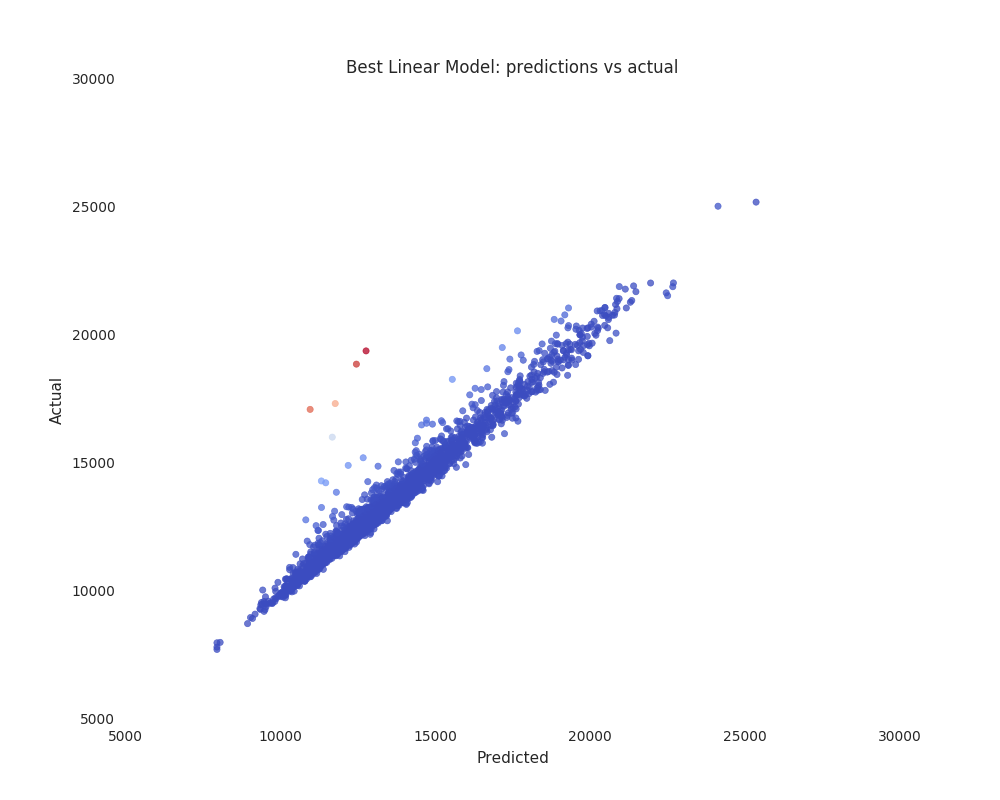

In [16]:
# Visualizing results(predictions) for best linear model
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap

# calculating predictions
reducedFeaturesVal = valData.map(lambda lp : LabeledPoint(lp.label,lp.features[LMbestFeatures]))
LRLabelsAndPreds = reducedFeaturesVal.map(lambda lp: (float(bestLinModel.predict(lp.features)), float(lp.label)))

preds = np.asarray(LRLabelsAndPreds.map(lambda lp: lp[0]).collect())
actual = np.asarray(LRLabelsAndPreds.map(lambda lp: lp[1]).collect())
error = np.asarray(LRLabelsAndPreds.map(lambda lp: (lp[1] - lp[0])**2).collect())

cmap = get_cmap('coolwarm')
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = plt.subplots(figsize=(10,8))
plt.scatter(preds, actual, c=clrs, edgecolors=clrs, alpha=0.75, linewidths=.5)
plt.title('Best Linear Model: predictions vs actual')
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig) 


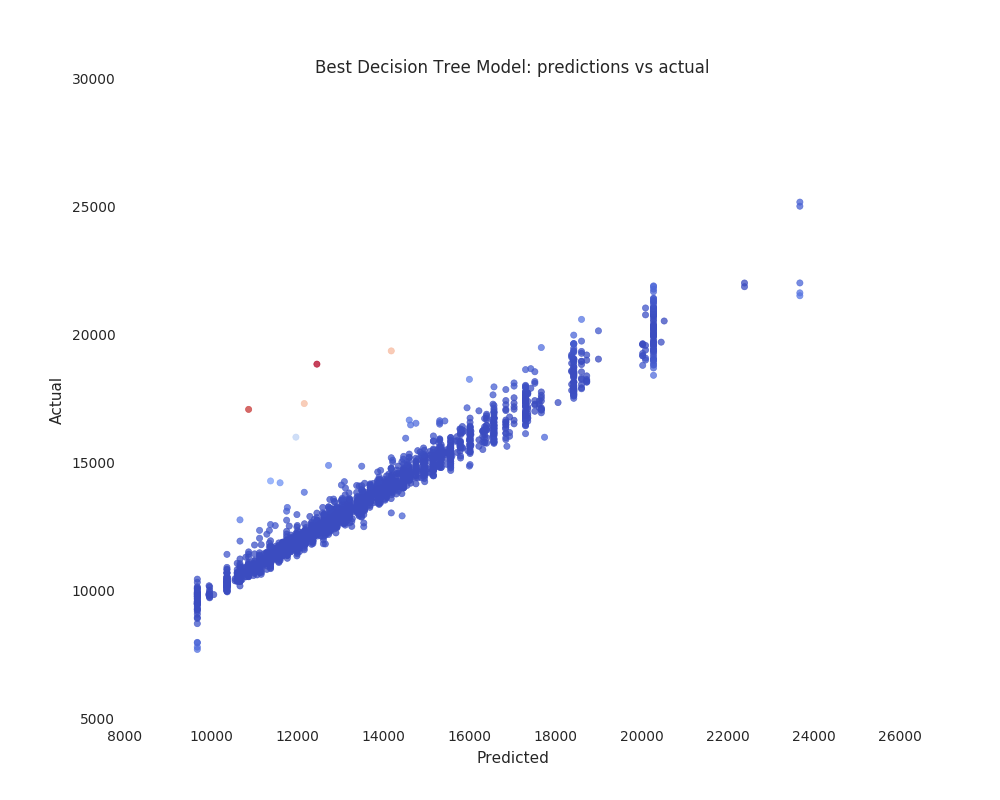

In [17]:
# Visualizing results(predictions) for best decision tree model

reducedFeaturesVal = valData.map(lambda lp : LabeledPoint(lp.label,lp.features[DTbestFeatures]))
predictions = bestTreeModel.predict(reducedFeaturesVal.map(lambda x: x.features))
DTLabelsAndPreds = reducedFeaturesVal.map(lambda lp: lp.label).zip(predictions)
DTLabelsAndPreds = DTLabelsAndPreds.map(lambda x: (x[0],x[1]))

preds = np.asarray(DTLabelsAndPreds.map(lambda lp: lp[1]).collect())
actual = np.asarray(DTLabelsAndPreds.map(lambda lp: lp[0]).collect())
error = np.asarray(DTLabelsAndPreds.map(lambda lp: (lp[1] - lp[0])**2).collect())

cmap = get_cmap('coolwarm')
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(preds, actual, c=clrs, edgecolors=clrs, alpha=0.75, linewidths=.5)
plt.title('Best Decision Tree Model: predictions vs actual')
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig) 


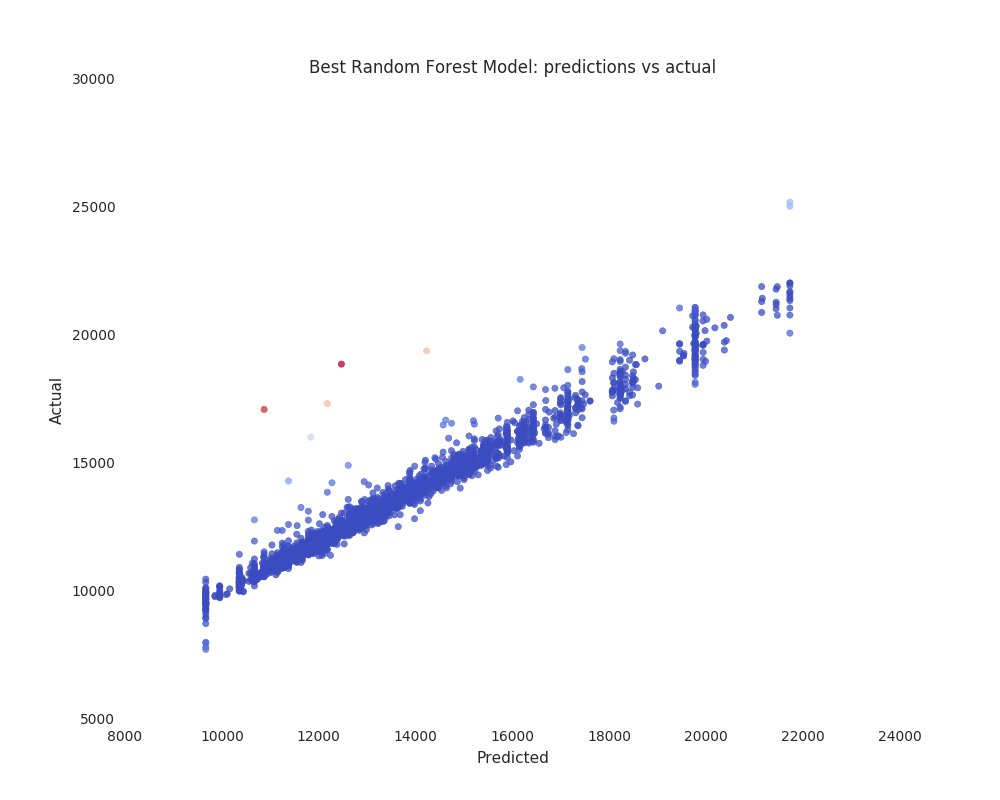

In [18]:
# Visualizing results(predictions) for best RANDOM FOREST model

reducedFeaturesVal = valData.map(lambda lp : LabeledPoint(lp.label,lp.features[RFbestFeatures]))
predictions = bestForestModel.predict(reducedFeaturesVal.map(lambda x: x.features))
RFLabelsAndPreds = reducedFeaturesVal.map(lambda lp: lp.label).zip(predictions)
RFLabelsAndPreds = RFLabelsAndPreds.map(lambda x: (x[0],x[1]))

preds = np.asarray(RFLabelsAndPreds.map(lambda lp: lp[1]).collect())
actual = np.asarray(RFLabelsAndPreds.map(lambda lp: lp[0]).collect())
error = np.asarray(RFLabelsAndPreds.map(lambda lp: (lp[1] - lp[0])**2).collect())

cmap = get_cmap('coolwarm')
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(preds, actual, c=clrs, edgecolors=clrs, alpha=0.75, linewidths=.5)
plt.title('Best Random Forest Model: predictions vs actual')
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig) 

In [19]:
# FINAL calculations for the best model
# which is Random Forest Model
  
reducedFeaturesTest = testData.map(lambda lp : LabeledPoint(lp.label,lp.features[RFbestFeatures]))
predictions = bestForestModel.predict(reducedFeaturesTest.map(lambda x: x.features))
RFLabelsAndPreds = reducedFeaturesTest.map(lambda lp: lp.label).zip(predictions)
metrics = RegressionMetrics(RFLabelsAndPreds)

print('RMSE for the best model on a test set:', metrics.rootMeanSquaredError)

RMSE for the best model on a test set: 450.032239597411

In [20]:
# comment: as I understand there is randomness in training Random Forest (trees are built on different random subsets)
# every time I run the code I got slightly different results (so here might be not the same as in presentation)
# at the same time the results for Linear Regression and Decisison tree models are the same between runs
# when seed is the same